In [202]:
# Pre-requisites
import numpy as np

# For plots
%matplotlib inline
import matplotlib.pyplot as plt

# To clear print buffer
from IPython.display import clear_output

# Importing functions from the previous tutorials:

In [289]:
# Initializing weight matrices from layer sizes
def initializeWeights(layers):
    weights = [np.random.randn(o, i+1) for i, o in zip(layers[:-1], layers[1:])]
    return weights

# Add a bias term to every data point in the input
def addBiasTerms(X):
        # Make the input an np.array()
        X = np.array(X)
        
        # Forcing 1D vectors to be 2D matrices of 1xlength dimensions
        if X.ndim==1:
            X = np.reshape(X, (1, len(X)))
        
        # Inserting bias terms
        X = np.insert(X, 0, 1, axis=1)
        
        return X

# Sigmoid function
def sigmoid(a):
    return 1/(1 + np.exp(-a))

# Forward Propagation of outputs
def forwardProp(X, weights):
    # Initializing an empty list of outputs
    outputs = []
    
    # Assigning a name to reuse as inputs
    inputs = X
    
    # For each layer
    for w in weights:
        # Add bias term to input
        inputs = addBiasTerms(inputs)
        
        # Y = Sigmoid ( X .* W^T )
        outputs.append(sigmoid(np.dot(inputs, w.T)))
        
        # Input of next layer is output of this layer
        inputs = outputs[-1]
        
    return outputs

# Compute COST (J) of Neural Network
def nnCost(weights, X, Y):
    # Calculate yPred
    yPred = forwardProp(X, weights)[-1]
    
    # Compute J
    J = 0.5*np.sum((yPred-Y)**2)/len(Y)
    
    return J

# IMPLEMENTING BACK-PROPAGATION WITH LEARNING RATE
# Added eta, the learning rate, as an input
def backProp(weights, X, Y, learningRate):
    # Forward propagate to find outputs
    outputs = forwardProp(X, weights)
    
    # For the last layer, bpError = error = yPred - Y
    bpError = outputs[-1] - Y
    
    # Back-propagating from the last layer to the first
    for l, w in enumerate(reversed(weights)):
        
        # Find yPred for this layer
        yPred = outputs[-l-1]
        
        # Calculate delta for this layer using bpError from next layer
        delta = np.multiply(np.multiply(bpError, yPred), 1-yPred)
        
        # Find input to the layer, by adding bias to the output of the previous layer
        # Take care, l goes from 0 to 1, while the weights are in reverse order
        if l==len(weights)-1: # If 1st layer has been reached
            xL = addBiasTerms(X)
        else:
            xL = addBiasTerms(outputs[-l-2])
        
        # Calculate deltaW for this layer
        deltaW = -np.dot(delta.T, xL)/len(Y)
        
        # Calculate bpError for previous layer to be back-propagated
        bpError = np.dot(delta, w)
        
        # Ignore bias term in bpError
        bpError = bpError[:,1:]
        
        # Change weights of the current layer (W <- W + eta*deltaW)
        w += learningRate*deltaW

# A function to check accuracy
def accuracy(weights, X, Y):
    yPred = forwardProp(X, weights)[-1]
    return np.sum([np.all((yPred[i]>0.5)!=Y[i]) for i in range(len(Y))])/float(len(Y))

# Initialize network
layers = [2, 2, 1]
weights = initializeWeights(layers)

print("weights:")
for i in range(len(weights)):
    print(i+1); print(weights[i].shape); print(weights[i])

# Declare input and desired output for AND gate
X = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = np.array([[0], [0], [0], [1]])

weights:
1
(2, 3)
[[-0.70293368 -0.85346313  1.24808122]
 [ 1.55773865  0.24196371  0.39007253]]
2
(1, 3)
[[ 0.35572419  0.95834148  1.11996833]]


# Batch Gradient Descent

Batch Gradient Descent is how we have tried to train our network so far - give it ALL the data points, compute ${\Delta}W$s by summing up quantities across ALL the data points, change all the weights once, Repeat.

Suppose we want to train our 3-neuron network to implement Logical XOR.

Inputs are: $X=\left[\begin{array}{c}(0,0)\\(0,1)\\(1,0)\\(1,1)\end{array}\right]$, and the desired output is $Y=\left[\begin{array}{c}0\\1\\1\\0\end{array}\right]$.

We know that in order to train the network, we need to call backProp repeatedly. Let us use a function to do that.

In [261]:
# TRAINING FUNCTION, USING GD
def train(weights, X, Y, nIterations, learningRate=1):
    for i in range(nIterations):
        # Clears screen output
        clear_output()
        
        print("Iteration "+str(i+1)+" of "+str(nIterations))
        
        # Run backprop
        backProp(weights, X, Y, learningRate)
        
        # Prints Cost and Accuracy
        print("Cost: "+str(nnCost(weights, X, Y)))
        print("Accuracy: "+str(accuracy(weights, X, Y)))

In [262]:
# Initialize network
layers = [2, 2, 1]
weights = initializeWeights(layers)

print("weights:")
for i in range(len(weights)):
    print(i+1); print(weights[i].shape); print(weights[i])

# Take backup of weights to be used later for comparison
initialWeights = [np.array(w) for w in weights]

weights:
1
(2, 3)
[[ 0.72044055  1.07239632 -0.10197306]
 [-0.26584414 -0.15396786 -1.10604823]]
2
(1, 3)
[[ 0.79691287  1.64620256  1.17547458]]


In [241]:
# Declare input and desired output for AND gate
X = np.array([[0,0], [0,1], [1,0], [1,1]])
Y = np.array([[0], [1], [1], [0]])

In [242]:
# Check current accuracy and cost
print("Cost: "+str(nnCost(weights, X, Y)))
print("Accuracy: "+str(accuracy(weights, X, Y)))

Cost: 0.125632295739
Accuracy: 0.5


Say we want to train our model 600 times.

In [245]:
nIterations = 400
train(weights, X, Y, nIterations)

Iteration 400 of 400
Cost: 0.0631832731629
Accuracy: 1.0


In [246]:
forwardProp(X, weights)[-1]

array([[ 0.36906037],
       [ 0.69797503],
       [ 0.57753259],
       [ 0.31553578]])

It took our function a long time to train.

What if we speed up using adaptive learning rate?

In [297]:
# TRAINING FUNCTION, USING GD
# Default learning rate = 1.0
def trainUsingGD(weights, X, Y, nIterations, learningRate=1.0):
    # Setting initial cost to infinity
    prevCost = np.inf
    
    # For nIterations number of iterations:
    for i in range(nIterations):
        # Run backprop
        backProp(weights, X, Y, learningRate)
        
        clear_output()
        print("Iteration "+str(i+1)+" of "+str(nIterations))
        cost = nnCost(weights, X, Y)
        print("Cost: "+str(cost))
        
        # ADAPT LEARNING RATE
        # If cost increases
        if (cost > prevCost):
            # Halve the learning rate
            learningRate /= 2.0
        # If cost decreases
        else:
            # Increase learning rate by 5%
            learningRate *= 1.05
        
        prevCost = cost

In [267]:
# Revert weights back to initial values
weights = [np.array(w) for w in initialWeights]

In [271]:
# Train for nIterations
# Don't expect same results for running with 20 iterations
# as with running twice with 10 iterations - learning rates are different!
nIterations = 100
trainUsingGD(weights, X, Y, nIterations)

Iteration 80 of 80
Cost: 0.00331565148282
Accuracy: 1.0


We see that with adaptive learning rate, we reach the desired output much faster!

# MNIST Dataset

MNIST is a dataset of 60000 images of hand-written numbers.

In [361]:
# Load MNIST DATA
# Use numpy.load() to load the .npz file
f = np.load('mnist.npz')
# Saving the files
x_train = f['x_train']
y_train = f['y_train']
x_test = f['x_test']
y_test = f['y_test']
f.close()

x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)


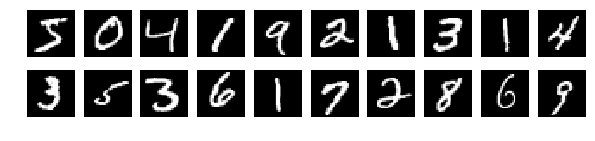

In [362]:
# To check MNIST data
print("x_train.shape = "+str(x_train.shape))
print("y_train.shape = "+str(y_train.shape))
fig = plt.figure(figsize=(10, 2))
for i in range(20):
    ax1 = fig.add_subplot(2, 10, i+1)
    ax1.imshow(x_train[i], cmap='gray');
    ax1.axis('off')

(In supervised learning) Every (good) dataset consists of a training set and a test set.

The training data set consists of data points and their desired outputs.

In this case, the data points are grayscale images of hand-written numbers, and their desired outputs are the numbers that have been drawn.

The test data set consists of data points whose outputs need to be found.

Let us implement the following neural network to classify MNIST data:
<center>![MNIST NN](images/digitsNN.png)

## Inintialize network

MNIST dataset has images of size 28x28. So the input layer to our network must have $28*28=784$ neurons.

Since we are tring to classify whether the image is that of 0 or 1 or 2 ... or 9, we need to have 10 output neurons, each catering to the probability of one number among 0-9.

Let our hidden layer (as shown in the diagram) have 15 neurons.

Before initializing the network though, let's ensure our inputs and outputs are appropriate for the task at hand.

## Are our inputs in the right format and shape?

Remember that we give inputs as np.arrays of $n{\times}784$ dimensions, $n$ being the number of data points we want to input to the network.

Is ``x_train`` an np.array?

In [363]:
# Check type of x_train
type(x_train)

numpy.ndarray

Yup, ``x_train`` is an np.array

Is ``x_train`` in the shape required by the network?

In [364]:
# Check shape of x_train
x_train.shape

(60000, 28, 28)

Clearly not.

We need to reshape this matrix to $60000{\times}784$.

In [365]:
# Reshaping x_train for our network with 784 inputs neurons
x_train = np.reshape(x_train, (len(x_train), 784))
x_test = np.reshape(x_test, (len(x_test), 784))

# Check the dimensions
x_train.shape

(60000, 784)

Now our input is in the right format and shape.

## Are our inputs normalized?

Remember that we had decided to limit the range of values for the input to 0-1.

Are all the values of ``x_train`` between 0 and 1?

In [366]:
# Check range of values of x_train
print("Values in x_train lie between "+str(np.min(x_train))+" and "+str(np.max(np.max(x_train))))

Values in x_train lie between 0 and 255


Our inputs are images, their values range from 0 to 255. We need to bring them down to 0-1.

In [367]:
# Normalize x_train
x_train = x_train / 255.0
x_test = x_test / 255.0

In [368]:
# Check range of values of x_train
print("Values in x_train lie between "+str(np.min(x_train))+" and "+str(np.max(np.max(x_train))))

Values in x_train lie between 0.0 and 1.0


Perfect.

## Are our outputs in the right format and shape?

Is ``y_train`` an np.array?

In [369]:
# Check type of y_train
type(y_train)

numpy.ndarray

Yup, ``y_train`` is an np.array

Remember that we have 10 neurons in the output layer. That means our output needs to be of ${n{\times}10}$ dimensions.

Is the shape of ``y_train`` $n{\times}10$?

In [370]:
# Check shape of y_train
y_train.shape

(60000,)

Nope, ``y_train`` is of shape $60000{\times}1$

What are its values like?

In [371]:
for i in range(5):
    print(y_train[i])

5
0
4
1
9


So ``y_train`` carries the numbers of the digits the images represent.

We need to make a new binary array of $60000{\times}10$ and insert a 1 in the column corresponding to the number of the digit its image shows.

For example, the first row of our new y_train should look like $\left[\begin{array}{c}0&0&0&0&0&1&0&0&0&0\end{array}\right]$, since it represents 5. This is called one-hot encoding.

In [372]:
# Make new y_train of nx10 elements
new_y_train = np.zeros((len(y_train), 10))
for i in range(len(y_train)):
    new_y_train[i, y_train[i]] = 1

In [373]:
# Make new y_test of nx10 elements
new_y_test = np.zeros((len(y_test), 10))
for i in range(len(y_test)):
    new_y_test[i, y_test[i]] = 1

In [374]:
# Check first row of y_train
print(new_y_train[0])
print(new_y_test[0])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


Now that new_y_train is correctly shaped and formatted, let us reassign the name y_train to the matrix new_y_train.

In [375]:
# Reassign the name "y_train" to new_y_train
y_train = new_y_train
y_test = new_y_test

## Initialize the network

In [376]:
# Initialize network
layers = [784, 15, 10]
weights = initializeWeights(layers)

# Take backup of weights to be used later for comparison
initialWeights = [np.array(w) for w in weights]

In [377]:
# Please don't print the weights
# There are 15*784=11760 weights in the first layer,
# + 10*10=150 weights in the second layer
'''
print("weights:")
for i in range(len(weights)):
    print(i+1); print(weights[i].shape); print(weights[i])
'''


'\nprint("weights:")\nfor i in range(len(weights)):\n    print(i+1); print(weights[i].shape); print(weights[i])\n'

## Train the network

Use the proper inputs ``x_train`` and ``y_train`` to train your neural network.

How many iterations do you want to perform? How much should be the learning rate? Should it be adaptive? How many neurons per layer?

Remember that there are 60,000 images in the training set.

In [378]:
# Train the network using Gradient Descent
# Let's check how much time it takes for 1 iteration
nIterations = 5
learningRate = 1.0
trainUsingGD(weights, x_train, y_train, nIterations, learningRate)

Iteration 5 of 5
Cost: 0.866387772823
Accuracy: 0.0


See how it takes SO LONG for just one iteration?

**Problem: Batch Gradient Descent computes error, delta, etc. over the entire input data set**

Solution: Don't change weights over the entire data set, repeatedly use a randomly sampled subset of the data set.

This is called the Monte Carlo method, and in this case it has been developed into Stochastic Gradient Descent.

# Stochastic Gradient Descent

We shall define a $minibatchSize$. Say $minibatchSize = 100$.

SGD:
- randomly choose ($minibatchSize$=)100 images out of the entire input data set
- use gradient descent on those 100 images to update weights
- Repeat.

So, at every iteration we are using gradient descent on only $minibatchSize$ number of images.

Mathematical proofs exist on why this works better than gradient descent, under some assumptions (like stationarity, which hold true for our purposes).

Let's code Stochastic Gradient Descent:

In [411]:
# TRAINING USING STOCHASTIC GRADIENT DESCENT
# Default learning rate = 1.0
def trainUsingSGD(weights, X, Y, minibatchSize, nIterations, learningRate=1.0):
    # Setting initial cost to infinity
    prevCost = np.inf
    
    # For nIterations number of iterations:
    for i in range(nIterations):
        # clear output
        #clear_output()
        print("Iteration "+str(i+1)+" of "+str(nIterations))
        
        # Make a list of all the indices
        fullIdx = list(range(len(Y)))
        
        # Shuffle the full index
        np.random.shuffle(fullIdx)
        
        # Choose only the first #minibatchSize number of indices
        idx = fullIdx[:minibatchSize]
        
        # Declare sampled inputs and outputs
        xSample = X[idx]
        ySample = Y[idx]
        
        # Run backprop
        backProp(weights, xSample, ySample, learningRate)
        
        '''
        # Calculate current cost of the network
        cost = nnCost(weights, X, Y)
        print("Cost: "+str(cost))
        # ADAPT LEARNING RATE
        # If cost increases
        if (cost > prevCost):
            # Halve the learning rate
            learningRate /= 2.0
        # If cost decreases
        else:
            # Increase learning rate by 5%
            learningRate *= 1.05
        '''
        
        # Updating prevCost at end of iteration
        prevCost = cost

Also, let us define an evaluation metric for the network.

In [437]:
def evaluate(weights, X, Y):
    yPreds = forwardProp(X, weights)[-1]
    test_results = [(np.argmax(yPreds[i]), np.argmax(Y[i]))
                        for i in range(len(Y))]
    yes = sum(int(x == y) for (x, y) in test_results)
    print(str(yes)+" out of "+str(len(Y)))

Using SGD, training should take lesser time.

In [444]:
# Initialize network
layers = [784, 30, 10]
weights = initializeWeights(layers)

# Take backup of weights to be used later for comparison
initialWeights = [np.array(w) for w in weights]

In [445]:
evaluate(weights, x_test, y_test)

850 out of 10000


In [446]:
# Train the network using Stochastic Gradient Descent
minibatchSize = 2000
nIterations = 1000
learningRate = 1.0
trainUsingSGD(weights, x_train, y_train, minibatchSize, nIterations, learningRate)

Iteration 1 of 1000
Iteration 2 of 1000
Iteration 3 of 1000
Iteration 4 of 1000
Iteration 5 of 1000
Iteration 6 of 1000
Iteration 7 of 1000
Iteration 8 of 1000
Iteration 9 of 1000
Iteration 10 of 1000
Iteration 11 of 1000
Iteration 12 of 1000
Iteration 13 of 1000
Iteration 14 of 1000
Iteration 15 of 1000
Iteration 16 of 1000
Iteration 17 of 1000
Iteration 18 of 1000
Iteration 19 of 1000
Iteration 20 of 1000
Iteration 21 of 1000
Iteration 22 of 1000
Iteration 23 of 1000
Iteration 24 of 1000
Iteration 25 of 1000
Iteration 26 of 1000
Iteration 27 of 1000
Iteration 28 of 1000
Iteration 29 of 1000
Iteration 30 of 1000
Iteration 31 of 1000
Iteration 32 of 1000
Iteration 33 of 1000
Iteration 34 of 1000
Iteration 35 of 1000
Iteration 36 of 1000
Iteration 37 of 1000
Iteration 38 of 1000
Iteration 39 of 1000
Iteration 40 of 1000
Iteration 41 of 1000
Iteration 42 of 1000
Iteration 43 of 1000
Iteration 44 of 1000
Iteration 45 of 1000
Iteration 46 of 1000
Iteration 47 of 1000
Iteration 48 of 1000
I

Iteration 380 of 1000
Iteration 381 of 1000
Iteration 382 of 1000
Iteration 383 of 1000
Iteration 384 of 1000
Iteration 385 of 1000
Iteration 386 of 1000
Iteration 387 of 1000
Iteration 388 of 1000
Iteration 389 of 1000
Iteration 390 of 1000
Iteration 391 of 1000
Iteration 392 of 1000
Iteration 393 of 1000
Iteration 394 of 1000
Iteration 395 of 1000
Iteration 396 of 1000
Iteration 397 of 1000
Iteration 398 of 1000
Iteration 399 of 1000
Iteration 400 of 1000
Iteration 401 of 1000
Iteration 402 of 1000
Iteration 403 of 1000
Iteration 404 of 1000
Iteration 405 of 1000
Iteration 406 of 1000
Iteration 407 of 1000
Iteration 408 of 1000
Iteration 409 of 1000
Iteration 410 of 1000
Iteration 411 of 1000
Iteration 412 of 1000
Iteration 413 of 1000
Iteration 414 of 1000
Iteration 415 of 1000
Iteration 416 of 1000
Iteration 417 of 1000
Iteration 418 of 1000
Iteration 419 of 1000
Iteration 420 of 1000
Iteration 421 of 1000
Iteration 422 of 1000
Iteration 423 of 1000
Iteration 424 of 1000
Iteration 

Iteration 754 of 1000
Iteration 755 of 1000
Iteration 756 of 1000
Iteration 757 of 1000
Iteration 758 of 1000
Iteration 759 of 1000
Iteration 760 of 1000
Iteration 761 of 1000
Iteration 762 of 1000
Iteration 763 of 1000
Iteration 764 of 1000
Iteration 765 of 1000
Iteration 766 of 1000
Iteration 767 of 1000
Iteration 768 of 1000
Iteration 769 of 1000
Iteration 770 of 1000
Iteration 771 of 1000
Iteration 772 of 1000
Iteration 773 of 1000
Iteration 774 of 1000
Iteration 775 of 1000
Iteration 776 of 1000
Iteration 777 of 1000
Iteration 778 of 1000
Iteration 779 of 1000
Iteration 780 of 1000
Iteration 781 of 1000
Iteration 782 of 1000
Iteration 783 of 1000
Iteration 784 of 1000
Iteration 785 of 1000
Iteration 786 of 1000
Iteration 787 of 1000
Iteration 788 of 1000
Iteration 789 of 1000
Iteration 790 of 1000
Iteration 791 of 1000
Iteration 792 of 1000
Iteration 793 of 1000
Iteration 794 of 1000
Iteration 795 of 1000
Iteration 796 of 1000
Iteration 797 of 1000
Iteration 798 of 1000
Iteration 

In [443]:
yPreds = forwardProp(x_train, weights)

np.argmax(yPreds[-1][0])

3

In [439]:
evaluate(weights, x_test, y_test)

1453 out of 10000


In [ ]:
a

In [384]:
len(y_test)

10000

In [401]:
from neuralnetworksanddeeplearning import *

training_data, validation_data, test_data = load_data_wrapper()

ImportError: No module named 'cPickle'